# Lab 4-7: Mixture Models+Model orden selection

The goal of this lab session is to study mixture models. In the first part you will code the EM algorithm to estimate the parameters of a GMM given the number of mixed distributions and in the second part you will try different model order selection methods. You will send only one notebook for both parts.

You have to send the filled notebook named **"L4_7_familyname1_familyname2.ipynb"** (groups of 2) by email to *violeta.roizman@l2s.centralesupelec.fr* by November 20, 2018 and put **"AML-L4-7"** in the subject. 

We begin with the standard imports:

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn import decomposition
import time
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
sns.set_context("paper")
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

We will have two toy datasets to try the different methods:

## GMM

A Gaussian mixture model is a probabilistic model that assumes all the data points are generated from a mixture of a finite number of Gaussian distributions with unknown parameters. After estimation of those parameters we get an estimation of the distribution of our data. For the clustering task, one can think of mixture models as generalizing k-means clustering to incorporate information about the covariance structure of the data as well as the centers of the latent Gaussians. 

### First part

Fill in the following class to implement a multivariate GMM:

In [4]:
class my_GMM():
    
    def __init__(self, k, initialization="kmeans",max_iter=100):
        '''
        Attributes:
        
        k_: integer
            number of components
        initialization_: {"kmeans", "random"}
            type of initialization
        mu_: np.array
            array containing means
        Sigma_: np.array
            array cointaining covariance matrix
        cond_prob_: (n, K) np.array
            conditional probabilities for all data points 
        labels_: (n, ) np.array
            labels for data points
        '''
        
        self.k_ = k
        self.initialization_ = initialization
        self.mu_ = None
        self.Sigma_ = None
        self.cond_prob_ = None
        self.labels_ = None
        self.p_ = None
        self.max_iter = max_iter
        
        
    def compute_condition_prob_matrix(self, X, mu, Sigma):
        '''Compute the conditional probability matrix 
        shape: (n, K)
        '''
        from scipy.stats import multivariate_normal
        n,p = X.shape
        CPM = np.zeros((n,self.k_))
        for i in range(n):

            for k in range(self.k_):

                CPM[i,k] = (multivariate_normal(mu[k], Sigma[k]).pdf(X[i]) * self.prob_[k])

            CPM[i] = CPM[i] / np.sum(CPM[i])

        return CPM   
    
    def compute_expectation(self, data_x, cond_prob):
        '''Compute the expectation to check increment'''
        
        n,p = data_x.shape

        ### Computing prob_t+1_k ###

        self.prob_ = np.mean(cond_prob, axis=0)

        ### Computing mean_t+1_k ###

        weighted = np.zeros((n,p))
        new_mu = np.zeros((self.k_,p))
        for k in range(self.k_):
            for i in range(n):
                weighted[i] = data_x[i] * cond_prob[i,k] / self.prob_[k]
            new_mu[k] = np.mean(weighted, axis=0) 

        self.mu_ = np.array(new_mu)

        ### Computing var_t+1_k ###

        weighted = np.zeros((n,p,p))
        new_sigma = np.zeros((self.k_,p,p))
        for k in range(self.k_):
            for i in range(n):
                weighted[i] = np.outer((data_x[i]-self.mu_[k]),(data_x[i]-self.mu_[k])) * cond_prob[i,k] / self.prob_[k]
            new_sigma[k] = np.mean(weighted, axis=0)             

        self.Sigma_ = np.array(new_sigma)
    
    def fit(self, X):
        """ Find the parameters mu_ and Sigma_
        that better fit the data
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """
        n,p = X.shape
        
        ######### Initialization of parameters ##########
        
        if self.initialization_ == "kmeans":
        
            from sklearn.cluster import KMeans
            kmeans = KMeans(self.k_, random_state=0)
            self.mu_ = kmeans.fit(X).cluster_centers_
            self.Sigma_ = np.array([(np.eye(p)) for k in range(self.k_)]) # [kmeans.transform(X).T @ kmeans.transform(X).T for k in range(self.k_)]
            self.prob_=np.ones(self.k_)*(1/self.k_)
            print('EM initialized with kmeans')
            
        else:

            self.mu_ = np.random.normal(size=(self.k_,p))
            self.Sigma_ = np.random.normal(size=(self.k_,p,p))**2
            self.prob_=np.ones(self.k_)*(1/self.k_)
            print('EM initialized randomly')
        
        ######### Iteration of Estimation-Maximisation ########
        
        converged = False
        n_it=0
        while n_it < 100:
            
            # Estimation
            
            self.cond_prob_ = self.compute_condition_prob_matrix(X, self.mu_, self.Sigma_)

            # Affectation 
            
               
            #Maximisation
            self.compute_expectation(X, self.cond_prob_)
            
            
            #Iteration
            n_it += 1
        
        ####### Labels assignation ########
        
        self.cond_prob_ = self.compute_condition_prob_matrix(X, self.mu_, self.Sigma_)
        
    def predict(self, X):
        """ Predict labels for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        label assigment        
        """
        n,p = X.shape
        cond_prob = self.compute_condition_prob_matrix(X, self.mu_, self.Sigma_)

        labels = [-1 for i in range(n)]
        for i in range(n):
            labels[i] = np.where(cond_prob[i] == np.max(cond_prob[i]))[0][0]
        return labels
        
    def predict_proba(self, X):
        """ Predict probability vector for X
        
        Parameters:
        -----------
        X: (n, p) np.array
            New data matrix
        
        Returns:
        -----
        proba: (n, k) np.array        
        """
        return self.compute_condition_prob_matrix(X, self.mu_, self.Sigma_)
    
    def sample(self, n_sample):
        """ Predict probability vector for X

        Parameters:
        -----------
        n_sample: int
            nb of sample to be generated

        Returns:
        -----
        sample: (n_sample, p) np.array        
        """
        from scipy.stats import multivariate_normal
        choices = np.random.choice(self.k_, n_sample)
        sample=[]
        for i in choices:
            sample.append(multivariate_normal(self.mu_[i],self.Sigma_[i]).rvs(1))
        return np.array(sample)

Generate your own mixture of Gaussian distributions to test the model, choose parameters so that GMM performs better than K-Means on it. Use `np.random.multivariate_normal`. 

Plot data with colors representing predicted labels and shapes representing real labels.

#### Training models

In [ ]:
p=6
nb_dot =100
from scipy.stats import multivariate_normal
centers=[(40, -20), (20,50), (30,30), (20,20), (-10,40)]
cov = [np.diag((20,10)),np.diag((20,80)),np.array([[300,10],[10,10]]),np.array([[200,10],[10,10]]),np.array([[50,30],[30,40]])]
data_synth = multivariate_normal((-0.75,2.25), np.diag((1,50))).rvs(nb_dot)
for i in range(p-1):
    data_synth = np.vstack((data_synth ,multivariate_normal(centers[i],cov[i]).rvs(nb_dot)))

gmm = my_GMM(p, initialization="kmeans",max_iter=200)
gmm.fit(data_synth)

In [7]:
from sklearn.cluster import KMeans
kmeans_test = KMeans(n_clusters=p, max_iter=200).fit(data_synth)

#### Plotting result

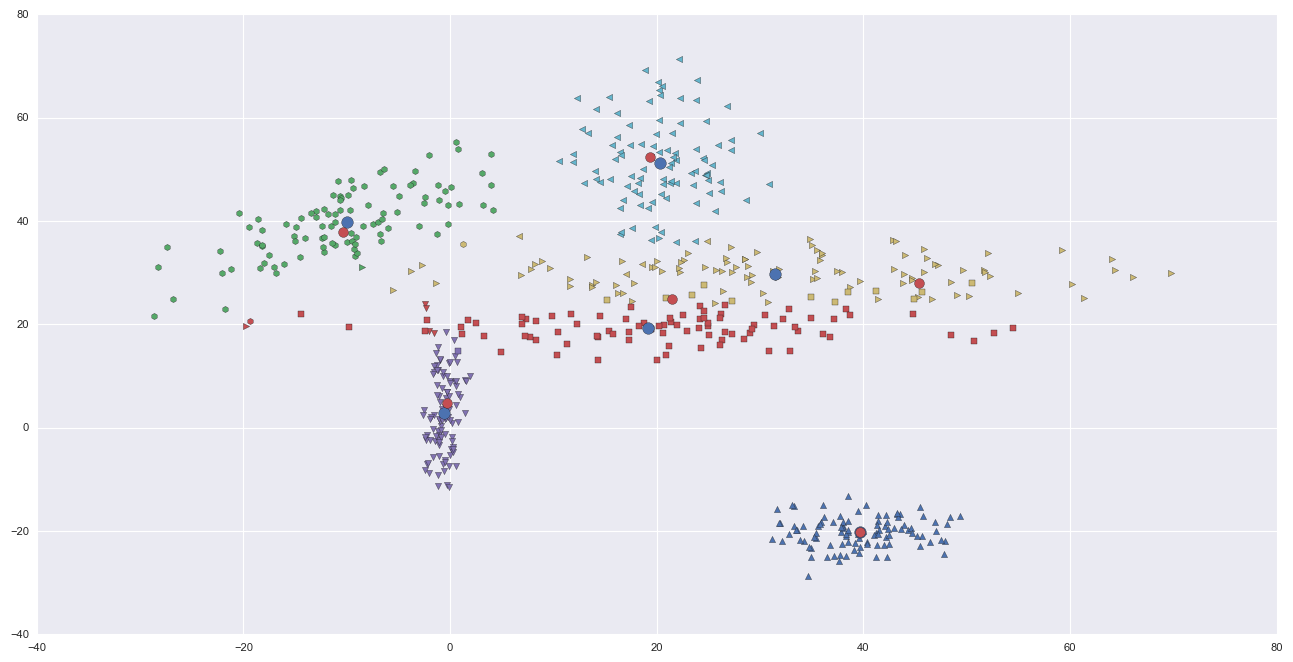

In [8]:
markers =["v","^","<",">","s","h"]
lab = [i for i in range(p)]
dic=dict(zip(lab,markers))
marker =[dic[i] for i in lab for k in range(nb_dot)]

colors = ["b","g","r","m","c","y"]
dic_col=dict(zip(lab,colors))
col =[dic_col[i] for i in gmm.predict(data_synth)]

fi, a = plt.subplots(1,1, figsize=(16,8))
for i in range(data_synth.shape[0]):
    a.scatter(data_synth[i,0],data_synth[i,1],c=col[i],marker=marker[i])
a.scatter(gmm.mu_.T[0],gmm.mu_.T[1], s=70)
a.scatter(kmeans_test.cluster_centers_.T[0],kmeans_test.cluster_centers_.T[1], s=50, c='r')

** The yellow and red clusters are better handled with Gaussian model rather than with the simple k-mean because of their anistropic shape (lean horizontal) ** Moreover, the label clustering of GMM (colors) is very close to the true label assignation (markers shape)

### Second Part
 
- Implement the seen information criterions (AIC, BIC, etc.) to select the number of clusters:

### AIC & BIC criterions

In [70]:
def AIC_BIC_gaussian(data, param_range):
    AIC={}
    BIC={}
    for k in param_range:
        print('computing AIC and BIC for k = {}'.format(k))
        gmm = my_GMM(k, initialization="kmeans",max_iter=100)
        gmm.fit(data)
        print('GMM_{} fitted'.format(k))
        labels = gmm.predict(data)
        mu = gmm.mu_
        Sigma = gmm.Sigma_
        proba=0
        for i in range(data.shape[0]):
            proba += multivariate_normal(mu[labels[i]],Sigma[labels[i]]).pdf(data[i])
        AIC[k]=np.log(proba)-k*5   #2 params for mu and 3 for Sigma by class
        BIC[k]=np.log(proba)-0.5*k*5*data.shape[0]
    return AIC, BIC 


In [71]:
AIC_test, BIC_test = AIC_BIC_gaussian(data_synth, [i for i in range(6,12)])

computing AIC and BIC for k = 6
EM initialized with kmeans
GMM_6 fitted
computing AIC and BIC for k = 7
EM initialized with kmeans
GMM_7 fitted
computing AIC and BIC for k = 8
EM initialized with kmeans
GMM_8 fitted
computing AIC and BIC for k = 9
EM initialized with kmeans
GMM_9 fitted
computing AIC and BIC for k = 10
EM initialized with kmeans
GMM_10 fitted
computing AIC and BIC for k = 11
EM initialized with kmeans
GMM_11 fitted


<Container object of 6 artists>

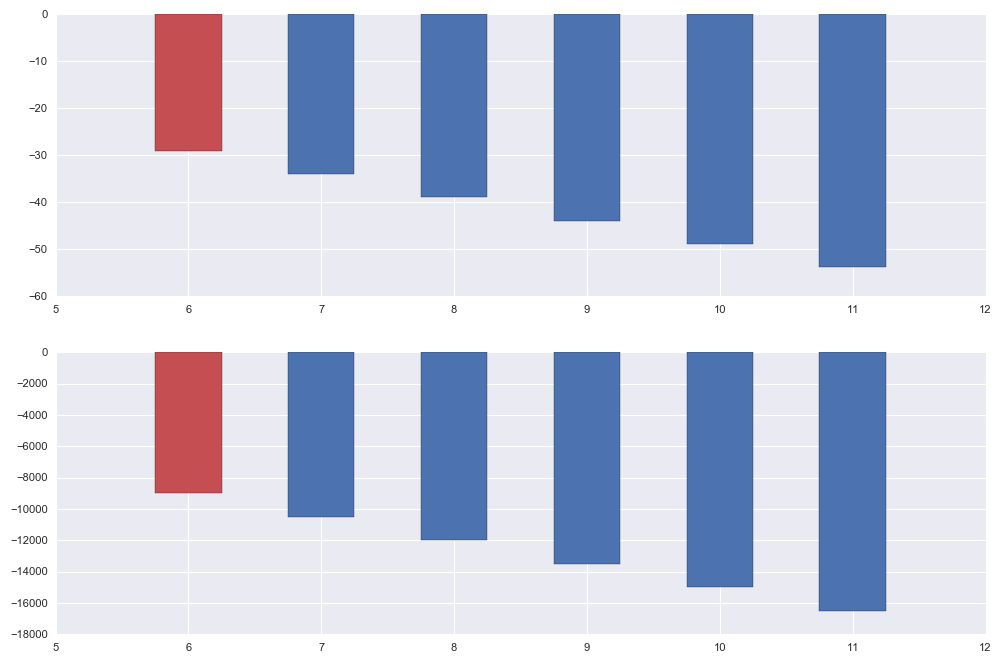

In [72]:
fig, a = plt.subplots(2,figsize=(12,8))
a[0].bar([6,7,8,9,10,11],[AIC_test[i] for i in [6,7,8,9,10,11]],color=['r','b','b','b','b','b'],align='center',width=0.5)
a[1].bar([6,7,8,9,10,11],[BIC_test[i] for i in [6,7,8,9,10,11]],color=['r','b','b','b','b','b'],align='center',width=0.5)

**Interpretation **: It seems that the order maximizing AIC and BIC is 6. This is mostly due to the penalty of increasing the number of parameters (as the training of our model is restrained to 100 iterations.)

### Merging criterions (based on conditional probabilities)

In [ ]:
def Classe_merger(X, min_class, mu, sigma, cond_proba, post_prob):

    K = mu.shape[0]
    dic_of_merging = {}
    it = 0
    while (K > min_class):
        it+=1
        # Selecting clusters to be merged
        current_ = 0
        for i_ind in range(K):
            for j_ind in range(K):
                if(i_ind < j_ind):
                    score = (post_prob[:,i_ind].T.dot(post_prob[:,j_ind]))/(np.linalg.norm(post_prob[:,i_ind])*np.linalg.norm(post_prob[:,j_ind]))
                    if(score > current_):
                        max_ = score
                        i = i_ind
                        j = j_ind
                        
        dic_of_merging[it]=[i,j]
        
        # Merging and updating values
        
        cluster_cond_proba = cond_proba[i] + cond_proba[j]
        cluster_mu = (cond_proba[i]*mu[i] + cond_proba[j]*mu[j])/cluster_cond_proba
        cluster_sigma = cond_proba[i]*(Sigma[i] + mu[i].T.dot(mu[i])) + cond_proba[j]*(Sigma[j] + mu[j].T.dot(mu[j])) /(cluster_cond_proba) - cluster_mu.Tdot(cluster_mu)
        cluster_posterior_prob = (cond_proba[i]*posterior_prob[i] + cond_proba[j]*posterior_prob[j])/cluster_cond_proba
        
        cond_proba = np.delete(cond_proba, [i,j])
        cond_proba = np.append(cond_proba, np.array(cluster_cond_proba),axis = 0)
        
        post_prob = np.delete(post_prob, [i,j], axis = 0)
        post_prob = np.append(post_prob, cluster_posterior_prob[np.newaxis,:], axis = 0) 
        
        mu = np.delete(mu, [i,j], axis = 0)
        mu = np.append(mu, cluster_mu[np.newaxis,:], axis = 0)
        
        Sigma = np.delete(sigmas, [i,j], axis = 0)
        Sigma = np.append(sigmas, cluster_sigma[np.newaxis,:], axis = 0)

        K += -1

    return mu, Sigma, cond_proba, post_prob, dic_of_merging

In [ ]:
GMM_to_be_merged = my_GMM(10, initialization="kmeans",max_iter=200)
GMM_to_be_merged.fit(data_synth)
labels = GMM_to_be_merged.predict(data_synth)
cond_proba = GMM_to_be_merged.predict_proba(data_synth)

mu_merged, Sigma_merged, cond_proba_merged, post_prob_merged, dic_of_merging = Classe_merger(data_synth, 6, GMM_to_be_merged.mu_, GMM_to_be_merged.Sigma_, cond_proba, post_proba)

** Nota Bene ** Hadn't had time to debug it properly

### Cross-validation (with likelihood as score function)

In [22]:
def Cross_validation(data, p, L=10):
    if 10*L>data.shape[0]: #hypothesis: having at least 10 items per subset
        print("Nb of subsets to big for data quantity, please choose a smaller L ")
    else:
        data = np.random.permutation(data)
        n_subsets = data.shape[0]//L
        print('Slicing data in {} subsets'.format(n_subsets))
        scores = []
        for i in range(n_subsets-1):
            print('Subset n° {}'.format(i))
            test = data[i*L:(i+1)*L]
            train = np.delete(data, np.arange(i,i+L), axis =0) 
            gmm = my_GMM(p, initialization="kmeans",max_iter=10)
            gmm.fit(train)
            scores.append(np.sum(np.max(gmm.predict_proba(test),axis = 0)))    
    return scores

In [38]:
Cross_validation_results = [Cross_validation(data_synth, i, L=60) for i in range(6,12)]

Slicing data in 10 subsets
Subset n° 0
EM initialized with kmeans
Subset n° 1
EM initialized with kmeans
Subset n° 2
EM initialized with kmeans
Subset n° 3
EM initialized with kmeans
Subset n° 4
EM initialized with kmeans
Subset n° 5
EM initialized with kmeans
Subset n° 6
EM initialized with kmeans
Subset n° 7
EM initialized with kmeans
Subset n° 8
EM initialized with kmeans
Slicing data in 10 subsets
Subset n° 0
EM initialized with kmeans
Subset n° 1
EM initialized with kmeans
Subset n° 2
EM initialized with kmeans
Subset n° 3
EM initialized with kmeans
Subset n° 4
EM initialized with kmeans
Subset n° 5
EM initialized with kmeans
Subset n° 6
EM initialized with kmeans
Subset n° 7
EM initialized with kmeans
Subset n° 8
EM initialized with kmeans
Slicing data in 10 subsets
Subset n° 0
EM initialized with kmeans
Subset n° 1
EM initialized with kmeans
Subset n° 2
EM initialized with kmeans
Subset n° 3
EM initialized with kmeans
Subset n° 4
EM initialized with kmeans
Subset n° 5
EM initial

,k= 6,k= 7,k= 8,k= 9,k= 10,k= 11
0,0.999886,0.974579,0.931872,0.893748,0.816465,0.749719
1,0.999991,0.991404,0.900528,0.966072,0.941370,0.755893
2,0.999949,0.982195,0.873588,0.863353,0.946084,0.877379
3,0.999893,0.995356,0.892372,0.826055,0.945902,0.906705
4,0.999649,0.956745,0.900752,0.918208,0.796967,0.891547
5,0.999950,0.945246,0.933988,0.951092,0.982000,0.927150
6,0.999684,0.928473,0.990218,0.785319,0.889095,0.921875
7,0.999460,0.990694,0.988543,0.920458,0.878936,0.881568
8,0.999676,0.932331,0.938967,0.843580,0.822121,0.923039


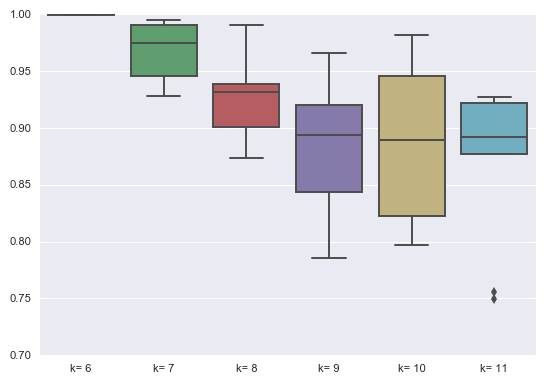

In [66]:
Cross_val_weighted=np.zeros((6,9))
for i in range(6):
    Cross_val_weighted[i] = np.array(Cross_validation_results)[i] / (i+6)
Cross_val = pd.DataFrame(Cross_val_weighted.T, columns = ['k= {}'.format(i+6) for i in range(6)])
sns.boxplot(Cross_val)
Cross_val

** Interpretation ** : It is clear that **the order that maximize the likelihood weighted by the number of parameters is k = 6**. Each subset of the cross_validation yealds very similar results compared to other orders and score higher than the every quantile of the other order cross_validation scores.

Use the model selection criterions to choose the number of clusters for the two given datasets (data-MM-i.csv). Compare the results and the computational time. Try to visually validate your results.

### Order selection of GMM for parameters 

In this part we will use sklearn implementation of GMM and its AIC and BIC methods as they have optimized performances over our implementation. In terms of computational time, Cross-validation is by far longer than AIC and BIC scores computation as we need to train a greater number of models. Although cross-validation offer strong guaranties about the robustness of our model with regard to the data as each data rows is used both in traning and testing.

dataset n°1 

The maximizing order for AIC is k = [3]
The maximizing order for BIC is k = [3] 

dataset n°2 

The maximizing order for AIC is k = [4]
The maximizing order for BIC is k = [4]


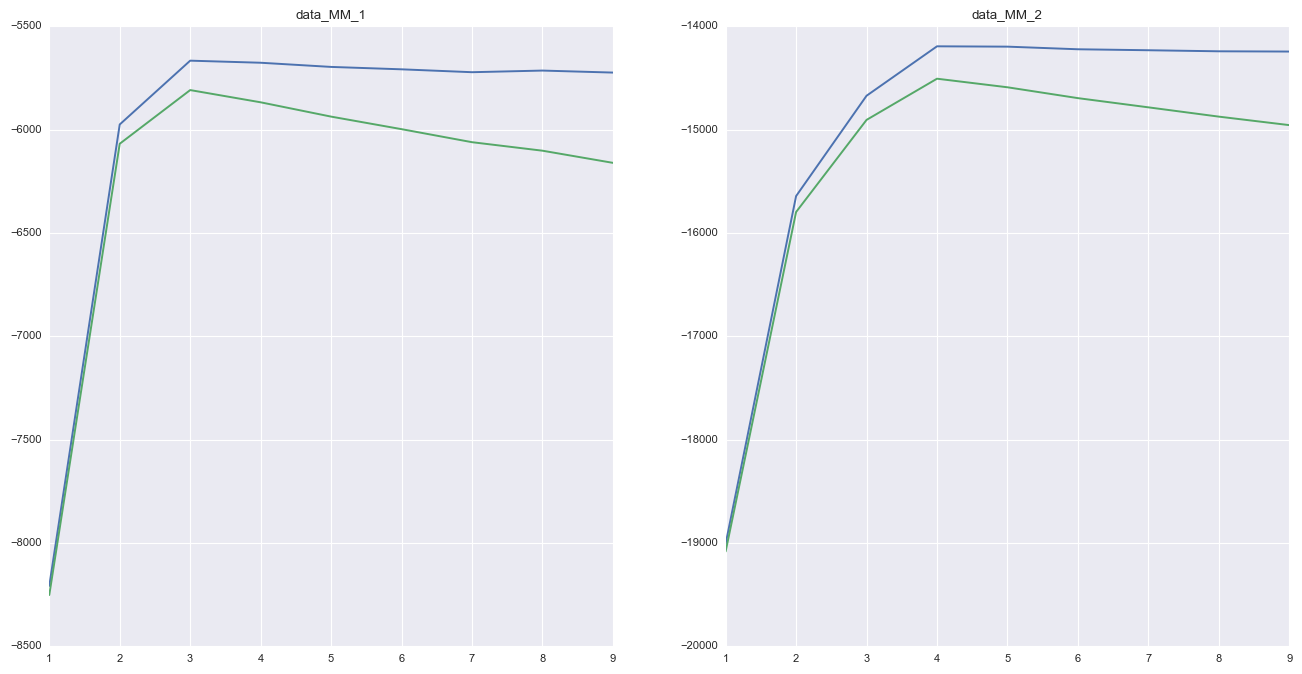

In [78]:
os.chdir('/Users/chalvidalm/Documents/3A OMA/OMA fonda/Machine Learning/Cours 8 - Order model selection/Data (1)')
data_MM_1 = np.loadtxt('data_MM_1.csv', delimiter=',')
data_MM_2 = np.loadtxt('data_MM_2.csv',delimiter=',')

fi, a = plt.subplots(1,2, figsize=(16, 8))

AIC = []
BIC = []
param_range = np.arange(1,10)
for k in param_range:
    gmm = GaussianMixture(k, random_state=0)
    AIC.append(-gmm.fit(data_MM_1).aic(data_MM_1))
    BIC.append(-gmm.bic(data_MM_1))

AIC_1 = []
BIC_1 = []
param_range = np.arange(1,10)
for k in param_range:
    gmm = GaussianMixture(k, random_state=0)
    AIC_1.append(-gmm.fit(data_MM_2).aic(data_MM_2))
    BIC_1.append(-gmm.bic(data_MM_2))

a[0].plot(param_range, AIC)
a[0].plot(param_range, BIC)
a[0].set_title('data_MM_1')
a[1].plot(param_range, AIC_1)
a[1].plot(param_range, BIC_1)
a[1].set_title('data_MM_2')

print('dataset n°1',"\n")
print('The maximizing order for AIC is k =', np.where(AIC == np.max(AIC))[0]+1,)
print('The maximizing order for BIC is k =', np.where(BIC == np.max(BIC))[0]+1,"\n")
print('dataset n°2',"\n")
print('The maximizing order for AIC is k =', np.where(AIC_1 == np.max(AIC_1))[0]+1, )
print('The maximizing order for BIC is k =', np.where(BIC_1 == np.max(BIC_1))[0]+1)

dataset n°1


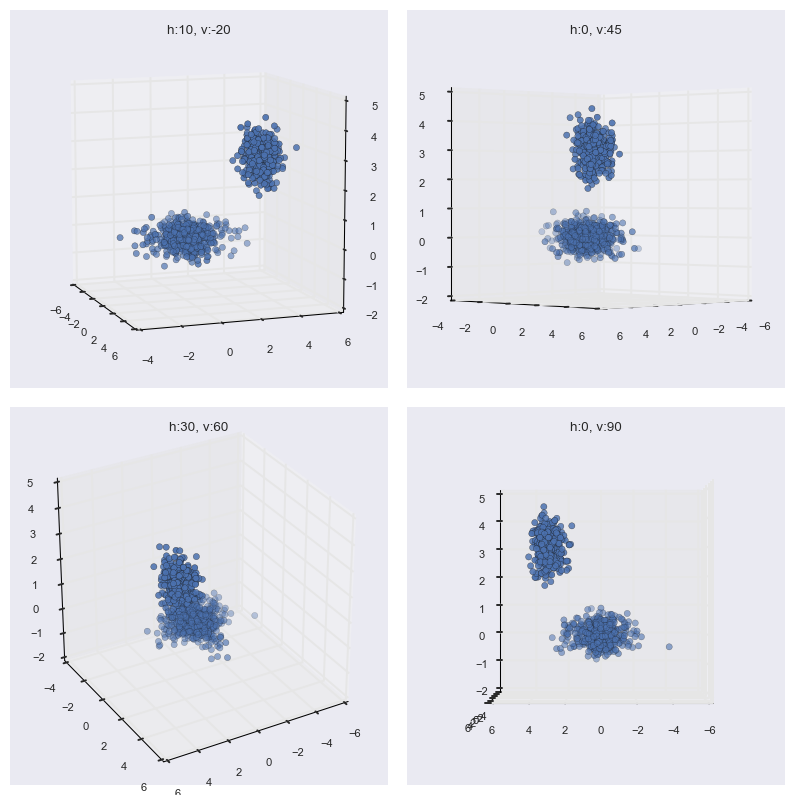

In [15]:
print('dataset n°1')
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
ax = fig.add_subplot(221, projection='3d')
ax.view_init(10, -20)
ax.set_title('h:10, v:-20')
ax.scatter(data_MM_1[:,0], data_MM_1[:,1], data_MM_1[:,2])
ax = fig.add_subplot(222, projection='3d')
ax.view_init(0, 45)
ax.set_title('h:0, v:45')
ax.scatter(data_MM_1[:,0], data_MM_1[:,1], data_MM_1[:,2])
ax = fig.add_subplot(223, projection='3d')
ax.view_init(30, 60)
ax.set_title('h:30, v:60')
ax.scatter(data_MM_1[:,0], data_MM_1[:,1], data_MM_1[:,2])
ax = fig.add_subplot(224, projection='3d')
ax.view_init(0, 90)
ax.set_title('h:0, v:90')
ax.scatter(data_MM_1[:,0], data_MM_1[:,1], data_MM_1[:,2])

dataset n°2


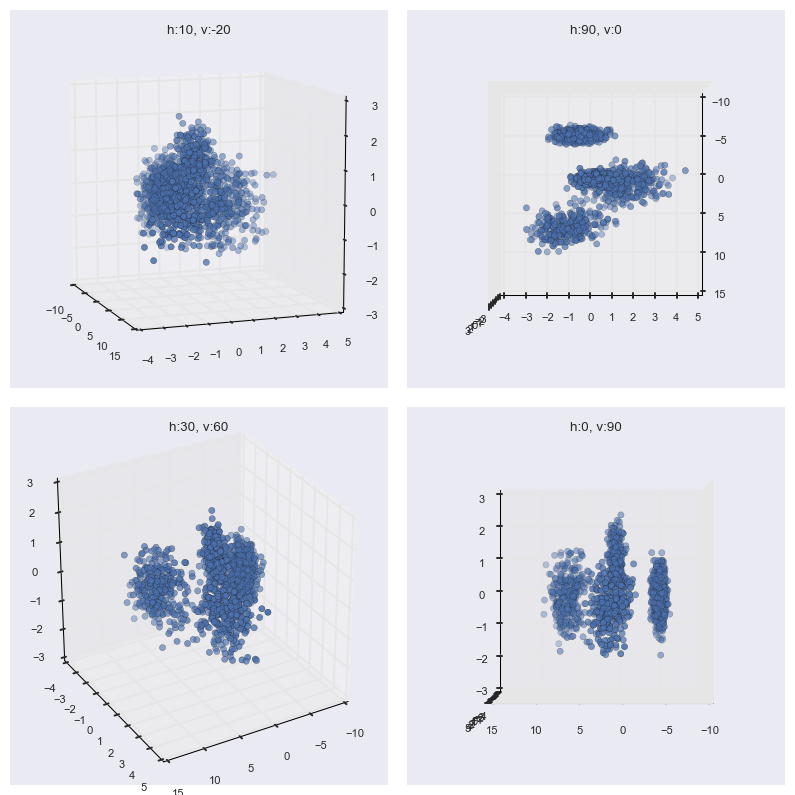

In [16]:
from sklearn.decomposition import PCA

pca = PCA(n_components = 3)
data_MM_2_embedded = pca.fit_transform(data_MM_2)

print('dataset n°2')
fig = plt.figure(figsize=(10, 10))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
ax = fig.add_subplot(221, projection='3d')
ax.view_init(10, -20)
ax.set_title('h:10, v:-20')
ax.scatter(data_MM_2_embedded[:,0], data_MM_2_embedded[:,1], data_MM_2_embedded[:,2])
ax = fig.add_subplot(222, projection='3d')
ax.view_init(90, 0)
ax.set_title('h:90, v:0')
ax.scatter(data_MM_2_embedded[:,0], data_MM_2_embedded[:,1], data_MM_2_embedded[:,2])
ax = fig.add_subplot(223, projection='3d')
ax.view_init(30, 60)
ax.set_title('h:30, v:60')
ax.scatter(data_MM_2_embedded[:,0], data_MM_2_embedded[:,1], data_MM_2_embedded[:,2])
ax = fig.add_subplot(224, projection='3d')
ax.view_init(0, 90)
ax.set_title('h:0, v:90')
ax.scatter(data_MM_2_embedded[:,0], data_MM_2_embedded[:,1], data_MM_2_embedded[:,2])

** Nota Bene ** : As the data is 4-dimensional, we embedded it into a 3-dimensional space in order to perform a scatter plot. It seems that the number of classes is 3 for this dataset.

** Interpretation ** Both AIC and BIC are higher for k=3 in the first and second dataset, however, it is only in the second dataset that we truely have 3 classes. In the first dataset, we can identify only 2 clearly distinct clusters.

## Application

You are going to work with the following data:

shape: (1797, 64)


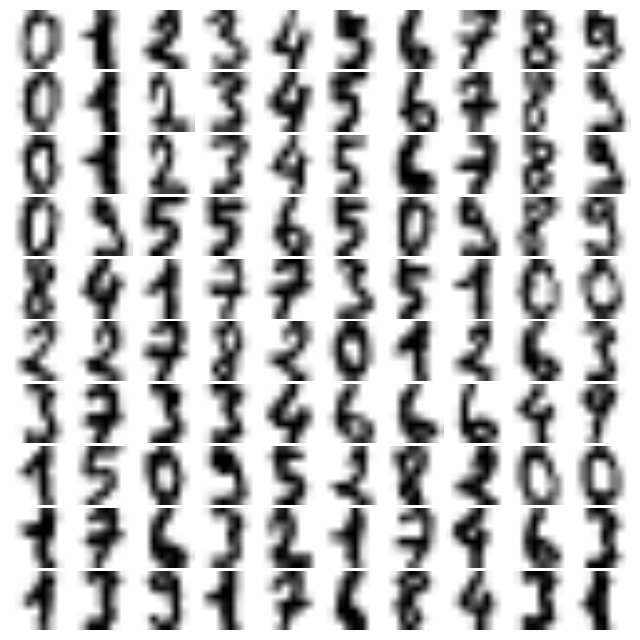

In [466]:
from sklearn.datasets import load_digits
digits = load_digits()
print("shape:", digits.data.shape)

def plot_digits(data):
    fig, ax = plt.subplots(10, 10, figsize=(8, 8),
                           subplot_kw=dict(xticks=[], yticks=[]))
    fig.subplots_adjust(hspace=0.05, wspace=0.05)
    for i, axi in enumerate(ax.flat):
        im = axi.imshow(data[i].reshape(8, 8), cmap='binary')
        im.set_clim(0, 16)
plot_digits(digits.data)

Model your data with your GMM class using a model order selection method and produce new synthetic handwritten numbers. You should use PCA to reduce the dimension as GMM doesn't perform well in high-dimensional contexts. 

In [467]:
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

pca = PCA(0.99, whiten=True)
digits = pca.fit_transform(digits.data)
digits.shape

(1797, 41)

**Nota Bene** we use scikit-learn implementation as our implementation is rather slow to fit such data. However, **it would work the same with our model** as we implemented a 'sample' method in order to generate data from the learnt clas paramters:

gmm = my_GMM(10, initialization="kmeans")

gmm.fit(digits)

data_new = gmm.sample(100)

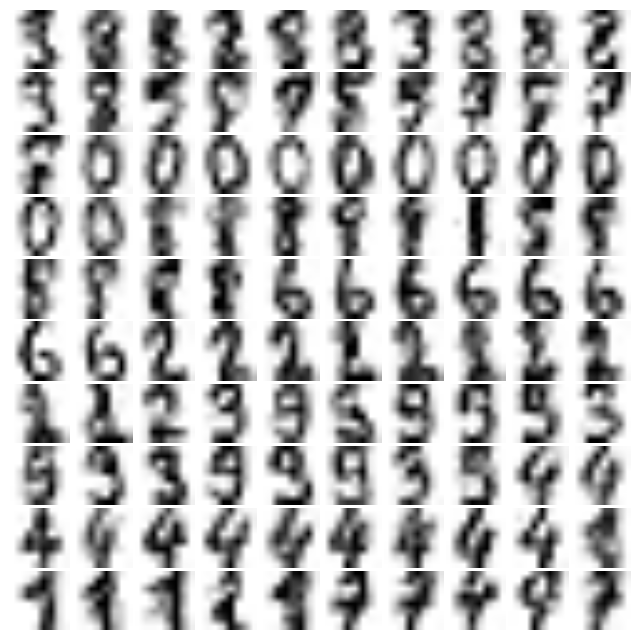

In [469]:
gmm = GaussianMixture(10, covariance_type='full', random_state=0)
gmm.fit(digits)

data_new = gmm.sample(100)
digits_new = pca.inverse_transform(data_new[0])
plot_digits(digits_new)